# Pipeline for the anomaly detection on the SkAB using FF Autoencoder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from evaluating import evaluating_change_point

## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# data loading
list_of_df = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file in all_files]

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(all_files)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 35

Shape of the random dataset: (1155, 10)

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB v1.0: 12938

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 12:14:36,0.027533,0.040251,1.225920,0.054711,70.6086,25.0660,230.831,32.0000,0.0,0.0
2020-03-09 12:14:37,0.027638,0.040555,1.212700,0.054711,70.6873,25.0797,232.721,32.0109,0.0,0.0
2020-03-09 12:14:38,0.027355,0.039930,1.353730,0.710565,70.7463,25.0850,251.194,32.9894,0.0,0.0
2020-03-09 12:14:39,0.028318,0.042112,0.813039,-0.273216,70.5657,25.0730,235.222,32.0000,0.0,0.0
2020-03-09 12:14:40,0.027336,0.040441,1.237940,0.054711,70.5550,25.0799,228.685,32.0109,0.0,0.0


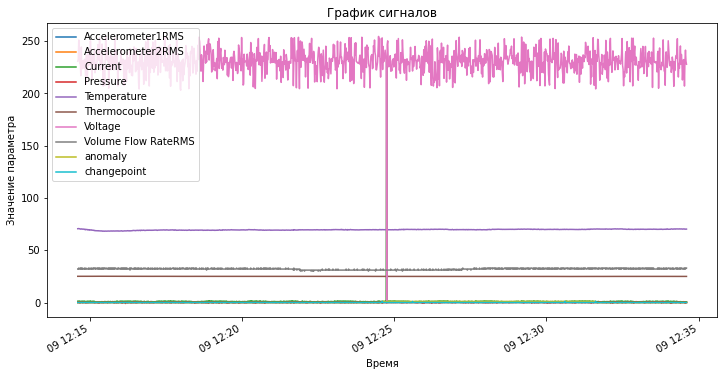

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Время')
plt.ylabel('Значение параметра')
plt.title(f'График сигналов')
plt.show()

## Labels

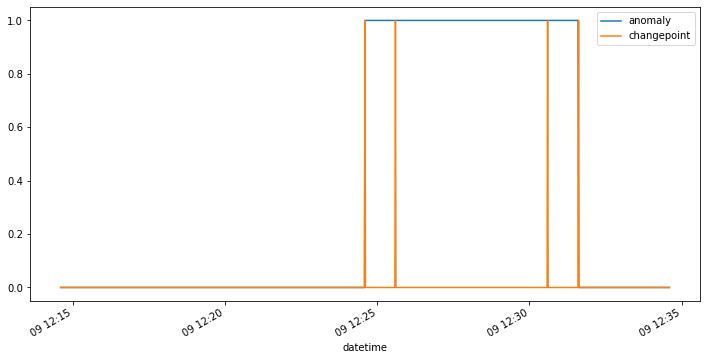

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,6))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [23]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

In [11]:
# Function for repeatability
def Random(seed_value):
    # Seed value
    # Apparently you may use different seed values at each stage
    seed_value= seed_value

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [12]:
# train set selection
X_train = list_of_df[0][:'2020-03-09 12:21'].drop(['anomaly','changepoint'], axis=1)

X_val = list_of_df[1][:'2020-03-09 12:41'].drop(['anomaly','changepoint'], axis=1)
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO
#TODO

In [13]:
StSc = StandardScaler()

# scaler fitting
StSc.fit(X_train)

StandardScaler()

In [14]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
N_STEPS = 5

# convert into input/output
X, y = split_sequences(StSc.transform(X_train), N_STEPS)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(N_STEPS, n_features)))
# model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(N_STEPS, n_features)))
model.add(LSTM(200, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mae', metrics=["mse"])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 200)            167200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
Total params: 489,608
Trainable params: 489,608
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("lstm.h5", save_best_only=True, verbose=0, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1)

epochs = 25
batch_size = 32

history = model.fit(X, y,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr]
                    )

Epoch 1/25
11/11 - 0s - loss: 0.8159 - mse: 1.0308 - val_loss: 0.6909 - val_mse: 0.8310
Epoch 2/25
11/11 - 0s - loss: 0.7773 - mse: 0.9652 - val_loss: 0.6551 - val_mse: 0.7905
Epoch 3/25
11/11 - 0s - loss: 0.7189 - mse: 0.8947 - val_loss: 0.6084 - val_mse: 0.7421
Epoch 4/25
11/11 - 0s - loss: 0.6668 - mse: 0.8349 - val_loss: 0.5894 - val_mse: 0.7188
Epoch 5/25
11/11 - 0s - loss: 0.6853 - mse: 0.8035 - val_loss: 0.5802 - val_mse: 0.7191
Epoch 6/25
11/11 - 0s - loss: 0.6413 - mse: 0.7586 - val_loss: 0.5743 - val_mse: 0.7184
Epoch 7/25
11/11 - 0s - loss: 0.6420 - mse: 0.7307 - val_loss: 0.6215 - val_mse: 0.7426
Epoch 8/25
11/11 - 0s - loss: 0.6483 - mse: 0.7338 - val_loss: 0.5972 - val_mse: 0.7228
Epoch 9/25
11/11 - 0s - loss: 0.5965 - mse: 0.6825 - val_loss: 0.5624 - val_mse: 0.7022
Epoch 10/25
11/11 - 0s - loss: 0.6152 - mse: 0.7251 - val_loss: 0.5557 - val_mse: 0.6979
Epoch 11/25
11/11 - 0s - loss: 0.6034 - mse: 0.6751 - val_loss: 0.5770 - val_mse: 0.7089
Epoch 12/25
11/11 - 0s - loss:

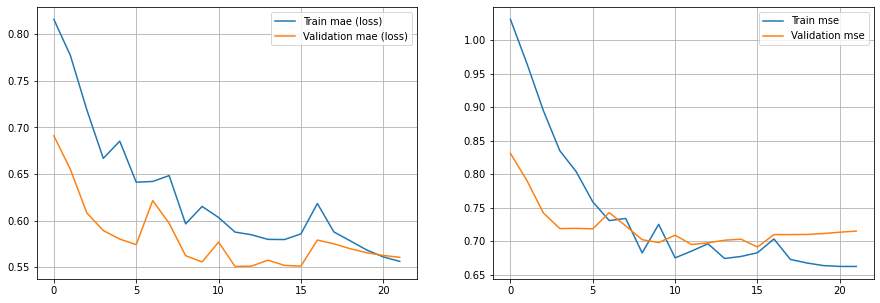

In [30]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train mae (loss)")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation mae (loss)")
ax_loss.grid()
ax_loss.legend()

ax_acc.plot(history.epoch, history.history["mse"], label="Train mse")
ax_acc.plot(history.epoch, history.history["val_mse"], label="Validation mse")
ax_acc.grid()
ax_acc.legend()
plt.show()

In [31]:
model.load_weights("lstm.h5")

In [33]:
X, y = split_sequences(StSc.transform(X_val), N_STEPS)
val_residuals = y - model.predict(X)

UCL = abs(pd.DataFrame(val_residuals)).sum(axis=1).quantile(0.90)

In [36]:
# inference
prediction = []
for df in list_of_df:
    X, y = split_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    lstm_residuals = y - model.predict(X)
    lstm = abs(pd.DataFrame(lstm_residuals)).sum(axis=1)
    prediction.append(pd.Series((lstm>UCL).astype(int).values, 
                                index=df[N_STEPS:].index).fillna(0))

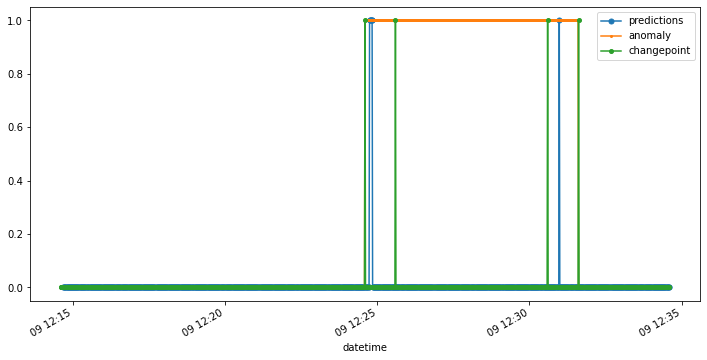

In [37]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

prediction[0].plot(figsize=(12,6), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
true_cp[0].plot(marker='o', markersize=4)
plt.legend();

In [38]:
# binary classification metrics calculation
binary = evaluating_change_point(true_outlier, prediction, metric='binary', numenta_time='30 sec')

False Alarm Rate 91.61 %
Missing Alarm Rate 7.43 %


In [39]:
# average detection delay metric calculation
# Missing values means a number of not detected changepoints
add = evaluating_change_point(true_cp, prediction, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:00.503937
Missing values: 3


In [40]:
# nab metric calculation
nab = evaluating_change_point(true_cp, prediction, metric='nab', numenta_time='30 sec')

большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
большая ширина плавного переходы сигмойды
Standart  -  -814.0
LowFP  -  -1725.69
LowFN  -  -510.1
